# Homework05

Some exercises with image and audio data preparation.

## Goals

- Even more practice with lists
- Get familiar with pandas `DataFrames`
- Practice dataset exploration and normalization/scaling
- Set up a dataset for proper classification

## Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [1]:
!wget -q https://github.com/PSAM-5020-2026S-A/5020-utils/raw/main/src/audio_utils.py
!wget -q https://github.com/PSAM-5020-2026S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2026S-A/5020-utils/raw/main/src/image_utils.py

!wget -q https://github.com/PSAM-5020-2026S-A/Homework03/raw/main/Homework03_utils.pyc
!wget -q https://github.com/PSAM-5020-2026S-A/Homework04/raw/main/Homework04_utils.pyc

!wget -qO- https://github.com/PSAM-5020-2026S-A/5020-utils/releases/latest/download/forest-tree.tar.gz | tar xz
!wget -qO- https://github.com/PSAM-5020-2026S-A/5020-utils/releases/latest/download/instruments.tar.gz | tar xz

!wget -q https://github.com/PSAM-5020-2026S-A/5020-utils/raw/refs/heads/main/datasets/audio/hood-internet.tar.gz
!tar -xzf ./hood-internet.tar.gz -C ./data/audio/ && rm -rf hood-internet.tar.gz

In [2]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import random

from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from os import listdir

from image_utils import make_image, get_pixels

from Homework05_utils import AwesomeAudioClassifier, AwesomeImageClassifier

AUDIO_PATH = "./data/audio/instruments/test"
IMAGE_PATH = "./data/image/forest-tree/test"

## More Image/Audio Classification

We're going to re-visit the classification exercises from `Homework04` and `Homework05`.

This exercise is a bit different though. In some ways it's the opposite of the previous exercises because we'll already have classification models ready to be used, but will have to normalize and standardize our dataset in order to run them. This is more representative of the type of work that goes into using real, pre-trained, ML models in the wild.

### The Models

We have two `Awesome` models, one for audio classification (`AwesomeAudioClassifier`), and one for image classification (`AwesomeImageClassifier`).

Unlike the classification models we set up for `Homework04` and `Homework05`, these models have more strict requirements about the shape and values of their input data. We can't run them on the files as they are.

### The Data

Audio and Image files are in the `data/audio/` and `data/image/` directories respectively.

We will use the `get_training_data()` from each of our classifiers to get the initial training data and labels for our audio and image files.

### The Features

This is the challenging part.

The data returned by `get_training_data()` is a representation of the content of the audio and image files, but it hasn't been processed or normalized in order to be used by the classifier models provided.

We can try to create a `DataFrame` directly from those, and it might seem like it works, but if we take a look at the result we'll see some `NaN` (Not-a-Number) values in some of the columns, and if we send that to the model it will barf and complain about having `NaN`s in the data.

This happens because all of the audios and images have different sizes. Hoooray !!

Welcome to Machine Learning. This is probably where most of the time in any ML project is spent: cleaning up data and making sure it has the right format, size and shape that a model expects.

For this exercise it won't be too hard to fix these.

Let's start with the audio files since they're one-dimensional, and once we have the audio modeling working we'll come back to the image files.

## Audio Data

Let's run `AwesomeAudioClassifier.get_training_data()` function to get some audio data. This function returns audio data and labels from files inside a specified directory.

In [3]:
features, labels = AwesomeAudioClassifier.get_training_data(AUDIO_PATH)

### Audio Features

The audio data returned is actually in the frequency domain and is not samples, so even though we can't play these audio files, we can still plot this data and will have to normalize and clean it before we can run it through our classifier.

Let's take a look at this data.

What are the labels ? How many records do we have ? How many features do we have in each record ? Can we plot our data ?

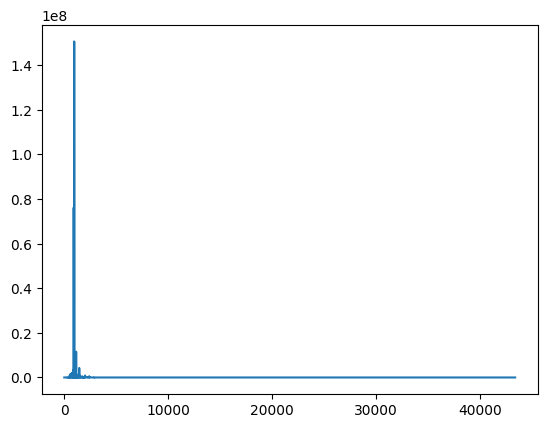

In [4]:
# TODO: How many records ? 
len(labels) 
# # TODO: How many features ? 
len(features[0]) 
# # TODO: Plot some features 
plt.plot(features[0])
plt.show()

### Looks like data !

Looks like audio frequency-domain data to be more specific.

If we were to follow some of the data exploration steps we saw in class we would want to put this data in a `DataFrame` in order to get calculate some of its statistical properties, and maybe scale/normalize it before we use it in a classifier model.

Let's try it:

In [5]:
features_df = pd.DataFrame(features)
features_df

,0,1,2,3,4,5,6,7,8,9,...,43533,43534,43535,43536,43537,43538,43539,43540,43541,43542
0,2209.0,172.0,39.0,2.0,0.0,1.0,14.0,29.0,147.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10442599.0,1261512.0,24.0,30.0,40.0,50.0,122.0,78.0,117.0,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,153391.0,24877.0,241.0,42.0,66.0,80.0,99.0,84.0,72.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,76499275.0,11668549.0,3906.0,107.0,394.0,32.0,234.0,2760.0,3923.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14136394.0,1554687.0,352.0,10.0,67.0,550.0,1933.0,1559.0,1288.0,164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,14259369.0,1647369.0,419.0,8.0,77.0,737.0,1993.0,2045.0,1411.0,178.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,670788.0,118085.0,260.0,0.0,36.0,24.0,2.0,29.0,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,82316585.0,10953710.0,3289.0,1423.0,389.0,12.0,31.0,3726.0,6086.0,398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
77,4055.0,496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like it works, but when we look closely at the `DataFrame`, specially if we look at the features that are further to the right, we'll see our problem: `NaN` values.

As previously mentioned, this happens because the length of our features is different for each file.

### Fix Audio Data

Let's fix this by making all of the feature lists have the same length. We can either pad the short ones or slice the longer ones to have the same length as the shortest feature list. The second option is preferable since padding would require adding information to the dataset and that might have side effects.

So, we'll go through the lists of lists, create a list of lengths and find the smallest length.

Then, we'll iterate through the lists of lists and slice all the feature lists to have the same length.

In [6]:
# TODO: go through the list of features and make their lengths consistent
min_len = min(len(row) for row in features)
cropped_features=[row[:min_len] for row in features]




A `DataFrame` created using the cropped features should look more consistent now.

In [7]:
features_df = pd.DataFrame(cropped_features)
features_df

,0,1,2,3,4,5,6,7,8,9,...,42990,42991,42992,42993,42994,42995,42996,42997,42998,42999
0,2209.0,172.0,39.0,2.0,0.0,1.0,14.0,29.0,147.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10442599.0,1261512.0,24.0,30.0,40.0,50.0,122.0,78.0,117.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,153391.0,24877.0,241.0,42.0,66.0,80.0,99.0,84.0,72.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,76499275.0,11668549.0,3906.0,107.0,394.0,32.0,234.0,2760.0,3923.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14136394.0,1554687.0,352.0,10.0,67.0,550.0,1933.0,1559.0,1288.0,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,14259369.0,1647369.0,419.0,8.0,77.0,737.0,1993.0,2045.0,1411.0,178.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,670788.0,118085.0,260.0,0.0,36.0,24.0,2.0,29.0,9.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,82316585.0,10953710.0,3289.0,1423.0,389.0,12.0,31.0,3726.0,6086.0,398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,4055.0,496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Bonus: Empty features

We've removed the `NaN` values, but it seems like we have a lot of columns that are all zeros or nearly all zeros, or are full of values that are close to zero, like `1e-7`.

While it's not necessary, we could also remove these in order to speed up the modeling later.

The `.loc[]` accessor of the `DataFrame` can be used to select columns using boolean indexing.

In [8]:
# sum of all columns
display(features_df.sum())

# columns where the sum is more than 100
display((features_df.sum() > 100))
col_mask = features_df.sum() > 0

# TODO: remove columns with no information
features_df = features_df.loc[:,col_mask]
features_df

0        567486224.0
1         76548890.0
2            59018.0
3            14074.0
4            18666.0
            ...     
42995            1.0
42996            0.0
42997            0.0
42998            0.0
42999            1.0
Length: 43000, dtype: float64

0         True
1         True
2         True
3         True
4         True
         ...  
42995    False
42996    False
42997    False
42998    False
42999    False
Length: 43000, dtype: bool

,0,1,2,3,4,5,6,7,8,9,...,42948,42949,42950,42951,42952,42953,42954,42994,42995,42999
0,2209.0,172.0,39.0,2.0,0.0,1.0,14.0,29.0,147.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10442599.0,1261512.0,24.0,30.0,40.0,50.0,122.0,78.0,117.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,153391.0,24877.0,241.0,42.0,66.0,80.0,99.0,84.0,72.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,76499275.0,11668549.0,3906.0,107.0,394.0,32.0,234.0,2760.0,3923.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14136394.0,1554687.0,352.0,10.0,67.0,550.0,1933.0,1559.0,1288.0,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,14259369.0,1647369.0,419.0,8.0,77.0,737.0,1993.0,2045.0,1411.0,178.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,670788.0,118085.0,260.0,0.0,36.0,24.0,2.0,29.0,9.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,82316585.0,10953710.0,3289.0,1423.0,389.0,12.0,31.0,3726.0,6086.0,398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,4055.0,496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Run the Model

Now that we have a `DataFrame` with consistent rows, we can fit and evaluate our model.

The next cell runs the pre-defined classification model, fitting it with our `features_df` `DataFrame` and then reports the accuracy of our model.

We just have to run it.

In [9]:
# Fit the classifier and report training accuracy
AwesomeAudioClassifier.fit(features_df, labels)

training accuracy: {'clarinet': 0.6, 'guitar': 1.0, 'piano': 0.0, 'overall': 0.53333}


### Scale / Normalize

Hmmm.... it runs, but we can do better.

We saw in class that normalizing/rescaling our features can help us find actual patterns in our data. It also helps models find patterns.

Try scaling the `DataFrame` using either a `MinMaxScaler` or a `StandardScaler` object.

In [10]:
# TODO: scale/normalize features
std_scaler = StandardScaler().set_output(transform="pandas")
features_scaled_df = std_scaler.fit_transform(features_df)

features_scaled_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x31526,x31527,x31528,x31529,x31530,x31531,x31532,x31533,x31534,x31535
0,-0.445743,-0.435935,-0.388470,-0.370459,-0.463666,-0.269175,-0.207421,-0.418568,-0.402271,-0.243515,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228
1,0.202304,0.131635,-0.396700,-0.311573,-0.385171,-0.145204,-0.010939,-0.357974,-0.421426,-0.146843,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228
2,-0.436359,-0.424818,-0.277645,-0.286336,-0.334149,-0.069303,-0.052782,-0.350555,-0.450159,-0.189492,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228
3,4.302517,4.814527,1.733111,-0.149637,0.309508,-0.190744,0.192821,2.958607,2.008751,-0.215082,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228
4,0.431582,0.263556,-0.216746,-0.353634,-0.332187,1.119806,3.283785,1.473441,0.326272,0.143172,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.439215,0.305260,-0.179988,-0.357840,-0.312563,1.592920,3.392942,2.074433,0.404809,0.182978,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228
75,-0.404243,-0.382877,-0.267221,-0.374665,-0.393020,-0.210984,-0.229253,-0.418568,-0.490385,-0.294694,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228
76,4.663604,4.492868,1.394601,2.617996,0.299696,-0.241345,-0.176494,4.153170,3.389853,0.808500,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228
77,-0.445628,-0.435789,-0.409867,-0.374665,-0.463666,-0.271705,-0.232891,-0.454430,-0.496132,-0.323127,...,-0.113228,-0.113228,-0.113228,-0.161165,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228,-0.113228


### Run the Model Again

This time with scaled data.

In [11]:
# Fit the classifier and report training accuracy
AwesomeAudioClassifier.fit(features_scaled_df, labels)

training accuracy: {'clarinet': 0.8, 'guitar': 0.7931, 'piano': 1.0, 'overall': 0.86437}


### Interpretation

<span style="color:hotpink;">
Do different scaling strategies influence the prediction results ? What might that tell us about our data ?
</span>

<span style="color:hotpink;">
EDIT THIS CELL WITH ANSWER
</span>

## Image Data

This is a bit trickier, but only because our classifier model for images is a bit pickier. Not only do we have to ensure that all of our records have the same number of features (images have the same number of pixels), we will also have to convert the pixels into grayscale pixels.

Let's start by reading the data and looking at what we get.

In [12]:
imgs, labels = AwesomeImageClassifier.get_training_data(IMAGE_PATH)

### Image Data

What did we get in the `imgs` variable ? How many records do we have ? How many features does each record/image have ?

In [13]:
imgs[:5]

[<PIL.Image.Image image mode=RGB size=189x189>,
 <PIL.Image.Image image mode=RGB size=181x181>,
 <PIL.Image.Image image mode=RGB size=197x197>,
 <PIL.Image.Image image mode=RGB size=212x212>,
 <PIL.Image.Image image mode=RGB size=153x153>]

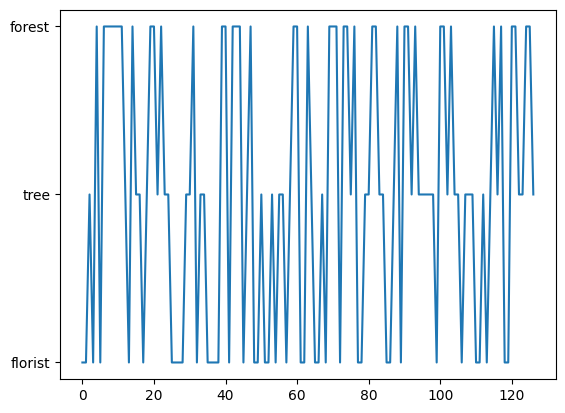

In [14]:
# TODO: look at the imgs and labels variables and get some information about the data
imgs[:5]
len(labels)
labels [:10]

plt.plot(labels)
plt.show()

### Create Image Features

It seems like we have actual `PIL` image objects and their labels. 

This will work to our advantage because if we try to just create a `DataFrame` of the extracted pixels from these images we'll probably have a problem with missing feature values again.

In [15]:
features = []
for img in imgs:
  features.append(get_pixels(img))

print(len(features), len(features[0]), len(features[11]))

features_df = pd.DataFrame(features)
features_df

127 35721 36481


,0,1,2,3,4,5,6,7,8,9,...,66039,66040,66041,66042,66043,66044,66045,66046,66047,66048
0,"(228, 203, 183)","(228, 203, 183)","(228, 203, 183)","(228, 203, 183)","(229, 204, 184)","(229, 204, 184)","(230, 205, 185)","(230, 205, 185)","(229, 204, 184)","(229, 204, 184)",...,None,None,None,None,None,None,None,None,None,None
1,"(213, 214, 208)","(216, 217, 211)","(218, 219, 213)","(218, 219, 213)","(215, 216, 210)","(214, 215, 209)","(217, 218, 212)","(220, 221, 215)","(218, 219, 213)","(205, 206, 200)",...,None,None,None,None,None,None,None,None,None,None
2,"(136, 164, 203)","(136, 164, 203)","(136, 164, 203)","(136, 164, 203)","(136, 164, 203)","(136, 164, 203)","(136, 164, 203)","(136, 164, 203)","(136, 164, 203)","(136, 164, 203)",...,None,None,None,None,None,None,None,None,None,None
3,"(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)",...,None,None,None,None,None,None,None,None,None,None
4,"(30, 45, 14)","(54, 69, 39)","(29, 44, 17)","(10, 22, 3)","(2, 6, 1)","(7, 17, 4)","(6, 14, 4)","(0, 10, 0)","(13, 26, 9)","(21, 34, 15)",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,"(238, 238, 238)","(238, 238, 238)","(238, 238, 238)","(238, 238, 238)","(238, 238, 238)","(238, 238, 238)","(238, 238, 238)","(238, 238, 238)","(240, 240, 240)","(236, 236, 236)",...,None,None,None,None,None,None,None,None,None,None
123,"(12, 12, 12)","(12, 12, 12)","(12, 12, 12)","(12, 12, 12)","(12, 12, 12)","(12, 12, 12)","(12, 12, 12)","(12, 12, 12)","(13, 13, 13)","(13, 13, 13)",...,None,None,None,None,None,None,None,None,None,None
124,"(80, 93, 75)","(40, 53, 35)","(58, 71, 53)","(31, 44, 26)","(46, 57, 41)","(1, 8, 1)","(9, 17, 3)","(43, 51, 36)","(50, 58, 46)","(28, 37, 23)",...,None,None,None,None,None,None,None,None,None,None
125,"(71, 92, 87)","(55, 77, 65)","(60, 85, 63)","(70, 97, 64)","(55, 86, 43)","(107, 141, 91)","(46, 79, 32)","(51, 85, 43)","(44, 79, 46)","(54, 90, 67)",...,None,None,None,None,None,None,None,None,None,None


### Fix Images

We could follow a similar approach to how we fixed the audio data, and just slice our pixel arrays to have the same length as the shortest pixel array, but that will distort our images. Try it out to see the result, but instead of taking pixels out from the end of the image, what we really have to do is change their dimensions so they all have the same `width` and `height` before we get their pixels.

There are a couple of ways to achieve this:
- Crop: use the `image.crop()` function to cut the images.
- Resize: use `image.resize()` to stretch/squeeze the images into specific shapes.

Documentation for [`crop()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop) and [`resize()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize).

Take a look at a few images before picking a strategy and then take a look after to see what the chosen strategy does to the images.

Min width: 142
Max width: 257
Min height: 142
Max height: 257
florist (135, 135)


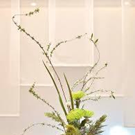

florist (135, 135)


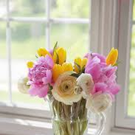

tree (135, 135)


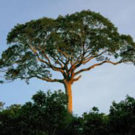

In [16]:
# TODO: look at characteristics/dimensions of the images
widths = [img.size[0] for img in imgs]
heights = [img.size[1] for img in imgs]

print("Min width:", min(widths))
print("Max width:", max(widths))
print("Min height:", min(heights))
print("Max height:", max(heights))

# TODO: go through the images and make their dimensions consistent
imgs_resized = []

for img in imgs:
  resized_img = img.resize((135,135))
  imgs_resized.append(resized_img)


# TODO: look at some images
for i in range (3):
  print(labels[i], imgs_resized[i].size)
  display(imgs_resized[i])

### Create Features

Now that we have images with consistent dimensions, we can extract their pixels and convert them to grayscale, so we get a nice looking `DataFrame` to send to our classifier model.

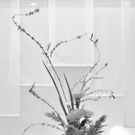

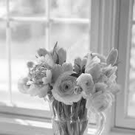

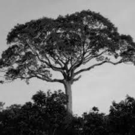

,0,1,2,3,4,5,6,7,8,9,...,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224
0,205.666667,205.666667,205.666667,206.666667,207.666667,207.666667,206.666667,206.666667,206.666667,206.666667,...,252.666667,253.000000,251.333333,249.666667,246.333333,242.000000,237.666667,235.666667,233.000000,233.333333
1,212.666667,216.666667,216.666667,214.333333,214.333333,218.666667,213.666667,197.666667,196.666667,213.666667,...,172.333333,172.333333,172.333333,172.333333,172.000000,170.000000,167.333333,165.000000,162.000000,159.333333
2,167.666667,167.666667,167.666667,167.666667,167.666667,167.666667,167.666667,167.666667,167.666667,167.666667,...,15.666667,15.000000,9.000000,14.666667,21.666667,14.333333,10.333333,6.666667,10.333333,10.333333
3,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
4,34.666667,51.000000,25.666667,9.333333,8.000000,11.000000,5.000000,14.000000,21.000000,27.333333,...,49.333333,73.333333,52.000000,35.666667,57.000000,52.000000,51.000000,68.333333,80.666667,38.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,238.000000,238.000000,238.000000,238.000000,239.000000,237.000000,236.000000,239.000000,236.000000,251.000000,...,252.000000,238.000000,235.000000,238.000000,237.000000,238.000000,238.000000,238.000000,238.000000,238.000000
123,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,13.000000,13.000000,13.000000,13.000000,...,10.333333,10.333333,10.333333,10.333333,11.333333,11.333333,11.333333,11.333333,11.333333,11.333333
124,68.666667,49.666667,34.333333,41.000000,20.333333,33.333333,41.666667,51.333333,63.666667,35.000000,...,19.333333,33.000000,25.666667,47.000000,98.666667,64.333333,64.000000,58.000000,64.666667,34.000000
125,76.000000,65.000000,71.666667,76.666667,112.000000,68.000000,61.333333,71.000000,67.666667,71.000000,...,48.000000,61.333333,42.333333,45.333333,44.333333,62.000000,68.666667,157.666667,132.333333,110.333333


In [34]:
# TODO: calculate grayscale pixel values
resized_features =[]
for img in imgs_resized:
  resized_features.append(get_pixels(img))

resized_features_df = pd.DataFrame(resized_features)

grayscale_features = []

for pixel_list in resized_features:
  gray_pixels = []
  for r,g,b in pixel_list:
   l = (r + g + b) /3
   gray_pixels.append(l)
  grayscale_features.append(gray_pixels)   

# TODO: look at some images with make_image()
for i in range(3):
  display(make_image(grayscale_features[i]))

# TODO: create DataFrame
grayscale_df = pd.DataFrame(grayscale_features)
grayscale_df

### Run the Image Model

Now that we have a `DataFrame` with consistent features, we can fit and evaluate our model.

The next cell runs the pre-defined classification model, fitting it with our `features_df` `DataFrame` and then reports the accuracy of our model.

We just have to run it (and wait a bit because it can take up to $20$ seconds for it to run).

In [31]:
# Fit the classifier and report training accuracy
AwesomeImageClassifier.fit(grayscale_df, labels)

training accuracy: {'florist': 0.95122, 'forest': 1.0, 'tree': 0.86364, 'overall': 0.93829}


### Scaling / Normalizing

Run the classifier model again, but this time using normalized features.

In [38]:
# TODO: create scaler object, scale data and re-run classification
std_scaler = StandardScaler().set_output(transform="pandas")
gray_scaled_df = std_scaler.fit_transform(grayscale_df)
gray_scaled_df

AwesomeImageClassifier.fit(gray_scaled_df, labels)


training accuracy: {'florist': 0.95122, 'forest': 1.0, 'tree': 0.86364, 'overall': 0.93829}


### Interpretation

<span style="color:hotpink;">
Do different scaling strategies influence the prediction results ? What might that tell us about our data ?
</span>

<span style="color:hotpink;">
Different scaling strategies didn't influence the prediction results. 
Is it because grayscale has done scaling already and further scaling didn't affect anything further? 
I tried to scale the resized images but it didn't work, so I thought grayscale is necessary for image classification but not very sure.
</span>

## Shazam !

Yep. Let's replicate the Shazam algorithm. It's the same type of classification task we've been looking at, but instead of classifying a piece of audio into one of $3$ classes, the algorithm has to pick which of the millions of songs the piece of audio most likely came from.

We've created some simple classification models by manually extracting features that we think are important for the differentiation of our classes. This is ok if we're only dealing with a few classes, but it doesn't scale. If we had to classify audio into hundreds, or thousands, of classes, looking at graphs of relative frequencies and loudness for all classes becomes intractable.

We need something a little more systematic. Something that automatically extracts meaningful numeric information from audio, independent of the type of audio.

Let's look at the frequency domain again, and use the librosa library to help us extract consistent frequency information from audio files.

## Librosa Feature Extraction

Librosa is useful because it has many feature extraction functions to actually get meaningful frequency information from our audios files:

[Librosa Reference and Documentation](https://librosa.org/doc/latest/feature.html)

### Some example functions

- `librosa.feature.spectral_centroid` (extracts average frequency)
- `librosa.feature.spectral_bandwidth` (extracts frequency range)
- `librosa.feature.spectral_rolloff(roll_percent=0.01)` (extarcts smallest frequency)
- `librosa.feature.spectral_rolloff(roll_percent=0.99)` (extracts largest frequency)

Let's load a song and see what running these looks like:

### ❗️❗️ WARNING ❗️❗️

The songs we'll be using are from mixtapes by [The Hood Internet](https://www.thehoodinternet.com/). They were part of a wave of _mashup_ producers in the early $2\text{,}000\text{s}$ that mixed "_classic_" american indie, pop and rap music from other time periods.

We're using their mixtapes here mostly because: they're available freely on the internet, they encompass a good variety of songs and styles, and there are a good number of songs; not too few nor too many.

The lyrics mostly come from the rap songs being sampled and contain references to all the things that rap artists were rapping about in the $90\text{s}$ and $00\text{s}$ (sex, drugs, guns, money...).

We definitely don't have to listen to the songs to complete the exercise.

And, I am looking for suggestions of alternative "datasets" for this exercise.

### Back to Features Extraction

In [ ]:
y,sr = librosa.load("./data/audio/hood-internet/mixtape04/02 David Banner x Fujiya & Miyagi - Get Like Pterodactyls.mp3")

plt.plot(y)
plt.show()

display(Audio(y, rate=sr))

This is how we extract the center frequency and the lowest/highest frequencies of our signal, throughout the song.

Because these functions were written to work with multi-channel audio, they'll always return a list of lists. In our case, we just have a single channel, so our result will be at index $0$ of the returned list.

That's why we have `sc[0]`, `smin[0]`, `smax[0]` below.

In [ ]:
# average frequency
sc = librosa.feature.spectral_centroid(y=y)

# min and max frequencies
smin = librosa.feature.spectral_rolloff(y=y, roll_percent=0.01)
smax = librosa.feature.spectral_rolloff(y=y, roll_percent=0.99)

plt.plot(sc[0])
plt.plot(smin[0])
plt.plot(smax[0])
plt.show()

This is a start.

The functions give us multiple values because the avg/min/max frequency changes over time, but we can average the `spectral_centroid` and the two `spectral_rolloff` frequencies to get $3$ values that represent our entire audio file.

In [ ]:
sc_val = sum(sc[0]) / len(sc[0])
smin_val = sum(smin[0]) / len(smin[0])
smax_val = sum(smax[0]) / len(smax[0])

plt.plot([0, len(sc[0])], [sc_val, sc_val])
plt.plot([0, len(smin[0])], [smin_val, smin_val])
plt.plot([0, len(smax[0])], [smax_val, smax_val])
plt.show()

Not bad.

### MFCCs

But, we can extend this idea with Mel-Frequency Cepstral Coefficients (MFCC). MFCCs are a compact, numerical representation of an audio signal's frequency characteristics, that divide an audio frequency range into bands based on human hearing sensitivities. So, instead of just $3$ frequencies, like we got above, the total frequency range is divided into $10$ to $20$ values that represent our audio signal.

And of course `librosa` has an `mfcc()` function:

In [ ]:
mfccs = librosa.feature.mfcc(y=y, n_mfcc=10)
print(mfccs.shape)

for vs in mfccs:
  plt.plot(vs)
plt.show()

### Average MFCCs

Like the `spectral_centroid()` function, the `mfcc()` function gives us multiple values for each frequency channel/band, since these change over time as the audio changes. We'll assume that one value per frequency band is enough and average them over time, so we end up with only $10$ numbers to represent our audio.

In [ ]:
mfccs_avg = mfccs.mean(axis=1)
print(mfccs_avg.shape)

for vs in mfccs_avg:
  plt.plot([0,100], [vs, vs])
plt.show()

### Back to Shazam

This is what's behind the [Shazam algorithm](https://www.youtube.com/watch?v=b6xeOLjeKs0): a large database of songs, where each song is described with only a few features so they can be organized, searched, queried and compared very very quickly.

Another [video](https://www.youtube.com/watch?v=kMNSAhsyiDg) reference.

Let's implement something like this.

We'll focus on a single album, with about $30$ songs, but the same strategy (with minor modifications) will work for datasets of many more songs.

Here's the outline of what we have to do:

1. Extract MFCC features from all songs in our data base (single album)
2. Create a dataset of song features
3. Given an input sound clip: extract its MFCC features
4. Find closest song in database by feature distance

In [ ]:
# First, let's grab all audio file names from our album directory

TRACKS_DIR = "./data/audio/hood-internet/mixtape04"
fnames = sorted([f for f in listdir(TRACKS_DIR) if f.endswith("mp3")])

In [ ]:
# Now we define a helper function that:
#   given a list of samples, 
#   returns a dictionary of extracted mfcc values

def get_features(y, n_mfcc=20):
  mfeats = {}
  mfccs = librosa.feature.mfcc(y=y, n_mfcc=n_mfcc).mean(axis=1)
  for idx,fcc in enumerate(mfccs):
    mfeats[f"mfcc{idx}"] = float(fcc)
  return mfeats

In [ ]:
# TODO: run the get_features() function in one of the loaded files
# TODO: check the output and see if it makes sense

### 1. Extract MFCC features from all songs

It takes about $20$ seconds to extract features for all songs.

In [ ]:
# TODO: Run the function on all tracks and extract their average MFCCs

# TODO: iterate over the list of filenames, open each file,
#       extract mfcc features and append result to a list

track_feats = []

### 2. Create `DataFrame` of song features

In [ ]:
# TODO: put results in pandas DataFrame using the from_records() function

### 3. Given an input sound clip: extract its MFCC features

In [ ]:
# Let's open track 02 (index 1) and get 5 seconds of audio from the center of the song

# Track 02
fpath = f"{TRACKS_DIR}/{fnames[1]}"
y_in, sr_in = librosa.load(fpath)

# get 5 seconds from middle of song
midx = int(len(y_in) // 2)
half_win = int(2.5 * sr_in)
samples_5sec = y_in[midx - half_win : midx + half_win]

feat_in = [get_features(samples_5sec)]

# And create DataFrame with MFCC features for the 5-second clip
in_df = pd.DataFrame.from_records(feat_in)
in_df

### 4. Find closest song in database by feature distance

Because both our dataset of song features and the features from the input clip we want to find are in `DataFrames`, we can do some `DataFrame` math to quickly calculate the difference between the input clip features and features from all of the songs in our song database. We'll use this to find the row in our dataset that is closest to the input audio.

We can start the process with this line of code:
```py
dists = (tracks_df - in_df.iloc[0]).abs().sum(axis=1)
```

Pretty intense. Let's break it down:

- `tracks_df - in_df.iloc[0]`: this subtracts the first (and only) row of the input `DataFrame` from every row of the song dataset. The result is another `DataFrame` with $34$ rows and $20$ columns, where the cells don't hold MFCC values anymore, but the difference between the values in the input clip and the values from the songs in the dataset.

- `.abs()`: the absolute value of the difference. After the subtraction, some of the values might be negative, but we only care about their magnitude; how different they are, and not which is larger/smaller. The result is another `DataFrame` of the same size as the previous, but now all values are positive.

- `.sum(axis=1)`: this sums the differences across the columns. The result is a `DataFrame` with $34$ rows and a single column with a value that represents how different each of the songs in the dataset is from the input clip. The larger the number, the more different the song is.

What we still have to do is find out which row has the shortest distance to our input clip.

We can do this in a variety of ways.

One possibility is to just loop over the values and use $2$ variables to keep track of the smallest difference value and the index of where that difference is.

A more general approach is to turn our `DataFrame` into a list of pairs of row indexes and difference values:

```py
[[0, difference], [1, difference], [2, difference], ...]
```

and sort by the difference values. As we'll see below, this approach has advantages.

We can turn our single-column `dists` `DataFrame` into a list like this using the `.to_dict()` function followed by the `.items()`.

The `.to_dict()` function turns the single-column `DataFrame` into a `Python` dictionary, like this:
```py
{
  0: difference,
  1: difference,
  2: difference,
  ...
}
```

And the `items()` function is the regular `Python` dictionary that gives us dictionary (`key`,`value`) pairs.

In [ ]:
dists = (tracks_df - in_df.iloc[0]).abs().sum(axis=1)
idx_dist_pairs = dists.to_dict().items()

# break these down into multiple steps and see if each step makes sense
(tracks_df - in_df.iloc[0]) # add abs, sum, to_dict and items one at a time

We still have to sort our distance pairs

In [ ]:
# TODO: sort the idx_dist_pairs list by the difference values
# TODO: after sorting, look at the first item and check if the index matches the index of the input song

### 5. Evaluate

We should calculate how often our Shazam algorithm is right.

This can be done by implementing the following set of steps:
1. Initialize a counter to keep track of number of correct predictions
2. For $N$ predictions (where $N$ can be $10$, $100$, $1000$, etc ...)
3. Pick a random track from the album
4. Pick a random $5$ second clip from the random track
5. Extract features, compare to features in `tracks_df` and predict which track it is
6. If prediction correct, increment correct predictions counter

Alternatively, instead of only incrementing the correct predictions counter when the correct track is the very first on the list of possible tracks, we can increment the counter if the correct track is in the $\text{top-}3$ predictions. This is the $\text{top-}3$ accuracy of our classifier, which, instead of being a binary measurement of right/wrong, also gives us a bit of credit for being "close".

In [ ]:
# TODO: write a function called random5() that
#       receives an audio file path, extracts MFCC features from 
#       a random 5-second portion of the audio and returns a DataFrame with the features

def random5(fpath):
  # TODO: implement here. random.randrange() can help
  return pd.DataFrame.from_records([])

We'll also need a function for comparing the `DataFrame` of songs and the `DataFrame` of the input clip.

We just have to wrap the mega-line of `Pandas` and the sorting from above in a function.

In [ ]:
# TODO: implement comparison function
def compare_predict(tracks_df, in_df):
  # implement here
  return []

Now we use the above defined functions to run some tests.

We'll want to run $200$ to $500$ tests, but we can start with $10$ or so just to make sure the code works.

In [ ]:
# TODO: pick a random song
# TODO: extract features from random 5-second clip of song
# TODO: compare, and keep track of correct predictions
# TODO: repeat
# TODO: print accuracy (number of correct predictions divided by total tests)

### Improve the Algorithm ?

Not bad.

(Re)Watch the Shazam video [here](https://www.youtube.com/watch?v=b6xeOLjeKs0). What's the one big difference between their algorithm and ours ?

(You don't have to improve the code. Just think about what could be some potential next steps.)